# This notebook must be run with the Vizgen_2 conda environment within the Vizgen.sif singularity container

In [1]:
# Imports
import scanpy as sc
import pandas as pd
import os
import string
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from tqdm import tqdm
import Mapping
import matplotlib.pyplot as plt
import multiprocessing as mp
from functools import partial

import skimage
import cv2
from skimage.morphology import disk, opening, closing
from scipy.ndimage import binary_fill_holes, label, distance_transform_edt
from skimage.segmentation import find_boundaries, watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from skimage.segmentation import watershed
import anndata
from adjustText import adjust_text
import gseapy as gp

# Transcript Pairwise Distance CDF

In [2]:
def load_distances(file_path):
    """
    Load the dictionary of normalized distances from an .npz file.

    Parameters:
        file_path (str): Path to the .npz file.
    
    Returns:
        dict: Dictionary of genes and their normalized distances.
    """
    data = np.load(file_path, allow_pickle=True)
    return {key: data[key] for key in data}

def plot_cdf(normalized_distances_dict, top_genes,save_path=None):
    """
    Plots the CDF for each gene in the top_genes list.

    Parameters:
        normalized_distances_dict (dict): Dictionary with genes as keys and lists of normalized distances as values.
        top_genes (list): List of top genes to plot.
    """
    for gene in top_genes:
        # Get the distances for the current gene
        distances = normalized_distances_dict[gene]
        
        # Sort the distances
        sorted_distances = np.sort(distances)
        
        # Calculate the cumulative percentage
        cdf = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances)
        
        # Plot the CDF
        plt.plot(sorted_distances, cdf, label=gene)
    
    # Configure plot
    plt.xlabel("Distance")
    plt.ylabel("Cumulative Percent")
    plt.title("CDF of Normalized Distances")
    plt.legend()
    plt.grid(True)
    plt.xlim([0,1])
    if save_path:
        plt.savefig(save_path,format='pdf')
    plt.show()
    
def combine_dictionaries(dict1, dict2):
    """
    Combines two dictionaries where keys are genes and values are arrays.
    If a key exists in both dictionaries, the arrays are concatenated.
    If a key exists in only one dictionary, it is included as is.

    Args:
    - dict1: First dictionary {key: array, ...}.
    - dict2: Second dictionary {key: array, ...}.

    Returns:
    - A combined dictionary with keys from both dict1 and dict2, and concatenated arrays where keys overlap.
    """
    combined_dict = {}

    # Get all unique keys from both dictionaries
    all_keys = set(dict1.keys()).union(dict2.keys())

    for key in all_keys:
        if key in dict1 and key in dict2:
            # Concatenate arrays if key exists in both
            combined_dict[key] = np.concatenate([dict1[key], dict2[key]])
        elif key in dict1:
            # Use the array from dict1 if key only exists there
            combined_dict[key] = dict1[key]
        elif key in dict2:
            # Use the array from dict2 if key only exists there
            combined_dict[key] = dict2[key]

    return combined_dict

In [3]:
normalized_distances_dict_4 = load_distances("distance_cdfs/normalized_distances_4.npz")
normalized_distances_dict_3 = load_distances("distance_cdfs/normalized_distances_3.npz")

normalized_distances = combine_dictionaries(normalized_distances_dict_3, normalized_distances_dict_4)

gene_observation_counts = {gene: len(distances) for gene, distances in normalized_distances.items()}
sorted_genes = sorted(gene_observation_counts.items(), key=lambda item: item[1], reverse=True)
top_200_genes = sorted_genes[:200]

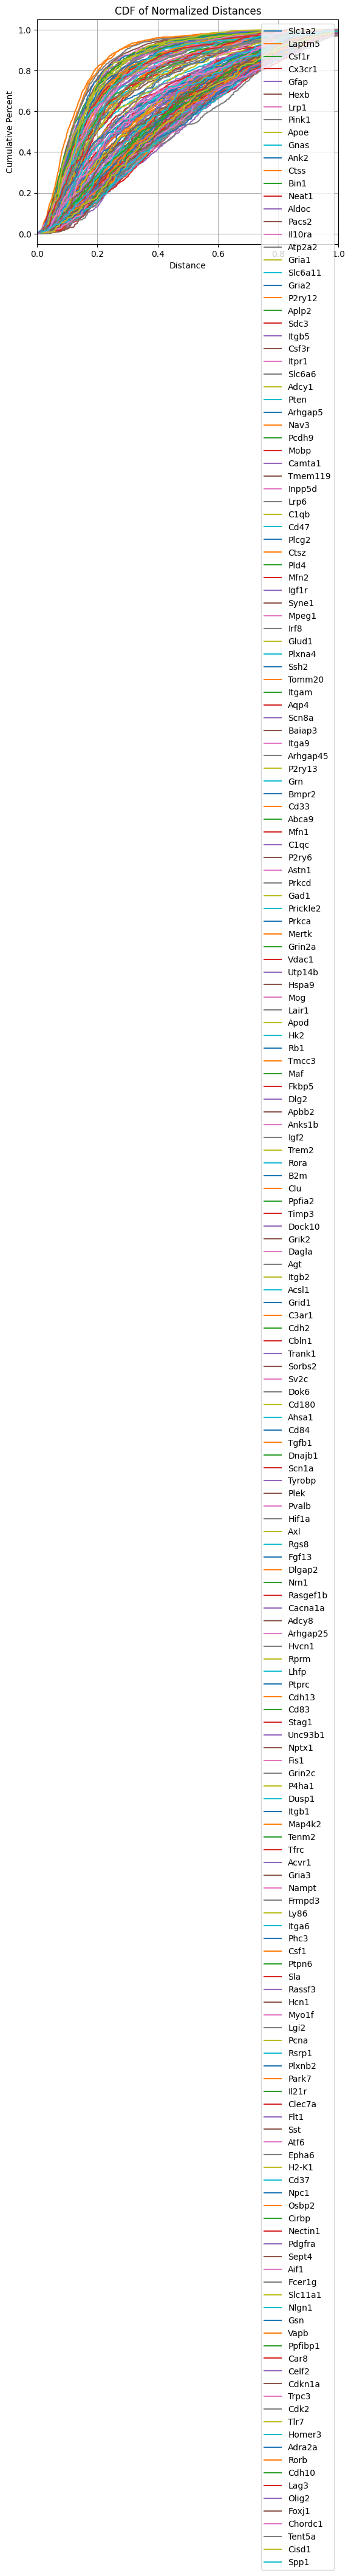

In [5]:
os.makedirs('Figures/Figure_4', exist_ok=True)
top_genes = [gene for gene, _ in top_200_genes]
plot_cdf(normalized_distances, top_genes,save_path='Figures/Figure_4/gene_cdf_full.pdf')

# Correlations

In [6]:
def shift_log_normalized(adata):
    """
    Shift log-normalized values to be non-negative.
    
    Parameters:
    adata : AnnData
        Annotated data matrix.
    
    Returns:
    AnnData
        AnnData object with shifted log-normalized values.
    """
    adata_copy = adata.copy()
    min_val = adata_copy.X.min()
    if min_val < 0:
        adata_copy.X = adata_copy.X - min_val
    return adata_copy

def differential_expression(adata1, adata2, shift_log_values=False):
    """
    Perform differential expression analysis between two AnnData objects.

    Parameters:
    adata1 : AnnData
        First annotated data matrix.
    adata2 : AnnData
        Second annotated data matrix.
    shift_log_values : bool
        Whether to shift log-normalized values to be non-negative.

    Returns:
    pd.DataFrame
        DataFrame containing differential expression results.
    """
    # Add a column indicating the origin of each cell
    adata1.obs['group'] = 'group1'
    adata2.obs['group'] = 'group2'

    if shift_log_values:
        adata1 = shift_log_normalized(adata1)
        adata2 = shift_log_normalized(adata2)

    # Concatenate the two AnnData objects
    adata_combined = adata1.concatenate(adata2, batch_key='batch', batch_categories=['group1', 'group2'])

    # Perform differential expression analysis using Scanpy
    sc.tl.rank_genes_groups(adata_combined, groupby='batch', reference='group1', method='wilcoxon',use_raw=False)

    # Extract results into a DataFrame
    results = adata_combined.uns['rank_genes_groups']
    groups = results['names'].dtype.names
    pvals = pd.DataFrame({group + '_pvals': results['pvals'][group] for group in groups})
    pvals_adj = pd.DataFrame({group + '_pvals_adj': results['pvals_adj'][group] for group in groups})
    logfoldchanges = pd.DataFrame({group + '_logfoldchanges': results['logfoldchanges'][group] for group in groups})
    names = pd.DataFrame({group + '_names': results['names'][group] for group in groups})

    return pd.concat([names, pvals, pvals_adj, logfoldchanges], axis=1)

def plot_volcano(
    df, 
    sig_lfc=0.5, 
    group='group2', 
    pval_col_suffix='_pvals', 
    logfc_col_suffix='_logfoldchanges', 
    name_col_suffix='_names', 
    title='Volcano Plot', 
    xlims=None, 
    savefig=None,
    figsize=(10, 6)
):
    """
    Plot a volcano plot for differential expression analysis results.

    Parameters:
    df : pd.DataFrame
        DataFrame containing differential expression results.
    group : str
        Group name for differential expression results.
    pval_col_suffix : str
        Suffix for the p-value column in the DataFrame.
    logfc_col_suffix : str
        Suffix for the log fold change column in the DataFrame.
    name_col_suffix : str
        Suffix for the gene names column in the DataFrame.
    title : str
        Title for the plot.
    xlims : tuple, optional
        Limits for the x-axis.
    savefig : str, optional
        Path to save the figure.

    Returns:
    list, list
        Two lists containing significant genes with log fold change < 1 and > 1, ordered by log fold change.
    """
    pvals = df[group + pval_col_suffix]
    logfoldchanges = df[group + logfc_col_suffix]
    gene_names = df[group + name_col_suffix]
    
    # Define significance thresholds
    sig_pval = 0.05
    sig_logfc = sig_lfc
    
    # Create the plot
    plt.figure(figsize=figsize)
    plt.scatter(logfoldchanges, -np.log10(pvals), color='grey', alpha=0.5, label='NS')
    
    # Highlight significant points
    sig_points = (pvals < sig_pval) & (np.abs(logfoldchanges) > sig_logfc)
    plt.scatter(logfoldchanges[sig_points], -np.log10(pvals[sig_points]), color='red', alpha=0.50, label='P-value and log2 FC')
    plt.scatter(logfoldchanges[(pvals < sig_pval) & ~sig_points], -np.log10(pvals[(pvals < sig_pval) & ~sig_points]), color='blue', alpha=0.50, label='P-value')
    plt.scatter(logfoldchanges[~(pvals < sig_pval) & (np.abs(logfoldchanges) > sig_logfc)], -np.log10(pvals[~(pvals < sig_pval) & (np.abs(logfoldchanges) > sig_logfc)]), color='green', alpha=0.50, label='Log2 FC')
    
    plt.axhline(y=-np.log10(sig_pval), color='black', linestyle='--')
    plt.axvline(x=sig_logfc, color='black', linestyle='--')
    plt.axvline(x=-sig_logfc, color='black', linestyle='--')
    
    # Annotate significant genes
    texts = []
    sig_genes_less_than_1 = []  # List for significant genes with logFC < -1
    sig_genes_greater_than_1 = []  # List for significant genes with logFC > 1

    for i in range(len(gene_names)):
        if sig_points[i]:
            if logfoldchanges[i] < -1 * sig_lfc:
                sig_genes_less_than_1.append((gene_names[i], logfoldchanges[i]))  # Store the gene and its logFC
            elif logfoldchanges[i] > sig_lfc:
                sig_genes_greater_than_1.append((gene_names[i], logfoldchanges[i]))  # Store the gene and its logFC

            texts.append(plt.text(logfoldchanges[i], -np.log10(pvals[i]), gene_names[i], fontsize=8))
    
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))
    
    plt.xlabel('Log2 fold change')
    plt.ylabel('-Log10 P-value')
    plt.title(title)
    plt.legend(loc='best')
    
    if xlims is not None:
        plt.xlim(xlims)
        
    if savefig is not None:
        plt.savefig(savefig, format='pdf')
        
    plt.show()
    
    # Sort the lists by the absolute value of log fold change
    sig_genes_less_than_1 = sorted(sig_genes_less_than_1, key=lambda x: abs(x[1]), reverse=True)
    sig_genes_greater_than_1 = sorted(sig_genes_greater_than_1, key=lambda x: abs(x[1]), reverse=True)

    # Extract only the gene names after sorting
    sig_genes_less_than_1 = [gene for gene, logfc in sig_genes_less_than_1]
    sig_genes_greater_than_1 = [gene for gene, logfc in sig_genes_greater_than_1]
    
    return sig_genes_less_than_1, sig_genes_greater_than_1

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import spearmanr
import numpy as np

def calculate_spearman_corr(adata, gene_columns, morpho_columns):
    """
    Calculate Spearman correlation between gene expression and morphological features.
    
    Parameters:
    - adata: AnnData object containing gene expression and morphological features.
    - gene_columns: List of gene names in adata.var_names.
    - morpho_columns: List of morphological feature names in adata.obs.
    
    Returns:
    - A DataFrame with Spearman correlation coefficients between genes and morphological features.
    """
    # Extract gene expression data (assume it's stored in adata.X or adata.var)
    gene_expr_df = pd.DataFrame(adata[:, gene_columns].X, columns=gene_columns, index=adata.obs_names)
    
    # Extract morphological features from adata.obs
    morpho_df = adata.obs[morpho_columns]
    
    # Initialize a DataFrame to store the correlations
    corr_matrix = pd.DataFrame(index=gene_columns, columns=morpho_columns)

    # Calculate Spearman correlation for each gene-morphological feature pair
    for gene in gene_columns:
        for morpho in morpho_columns:
            corr, _ = spearmanr(gene_expr_df[gene], morpho_df[morpho])
            corr_matrix.at[gene, morpho] = corr

    # Convert the correlation matrix to numeric values
    corr_matrix = corr_matrix.astype(float)

    return corr_matrix

In [7]:
ad_parent = sc.read_h5ad('../03_morph_embedding/Shape_500.h5ad')
ad_parent = ad_parent[ad_parent.obs.updated_celltype == 'Microglia']

ad_list = []
for batch in ad_parent.obs.batchID.unique():
    ad_viz = ad_parent[ad_parent.obs.batchID == batch].copy()
    
    total = pd.read_csv(f"transcript_out/{batch}_nuc_y_non_nuc.csv",index_col=0)
    non_nuc = pd.read_csv(f"transcript_out/{batch}_non_nuc.csv",index_col=0)
    
    ad_viz.layers['total_counts'] = total[ad_viz.var_names.intersection(total.columns)].to_numpy()
    ad_viz.layers['non_nuc_counts'] = non_nuc[ad_viz.var_names.intersection(non_nuc.columns)].to_numpy()
    
    ad_viz.layers['nuc_counts'] = ad_viz.layers['total_counts'] - ad_viz.layers['non_nuc_counts']
    
    ad_list.append(ad_viz)
    
combined_adata = anndata.concat(ad_list, axis=0)
adata = combined_adata.copy()
adata_s = combined_adata.copy()
adata_b = combined_adata.copy()

In [8]:
place_in_order = place_in_order = {
    0: '4',
    1: '1',
    2: '2',
    3: '0',
    4: '3',
}

adata_s.obs['ordered_morph'] = adata_s.obs.morph_leiden.map(place_in_order)
adata_b.obs['ordered_morph'] = adata_b.obs.morph_leiden.map(place_in_order)
adata.obs['ordered_morph'] = adata.obs.morph_leiden.map(place_in_order)

In [9]:
adata_s.X = adata_s.layers['nuc_counts']
sc.pp.normalize_total(adata_s,target_sum=1e4)
sc.pp.log1p(adata_s)

adata_b.X = adata_b.layers['non_nuc_counts']
sc.pp.normalize_total(adata_b,target_sum=1e4)
sc.pp.log1p(adata_b)

adata.X = adata.layers['total_counts']
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [10]:
soma_full = adata_s[(adata_s.obs.ordered_morph.isin(['3','4']))]
dendrites_full = adata_b[(adata_b.obs.ordered_morph.isin(['3','4']))]

soma_young = adata_s[(adata_s.obs.ordered_morph.isin(['3','4']))& (adata_s.obs.Age.isin(['3']))]
dendrites_young = adata_b[(adata_b.obs.ordered_morph.isin(['3','4']))& (adata_b.obs.Age.isin(['3']))]

soma_old = adata_s[(adata_s.obs.ordered_morph.isin(['3','4']))& (adata_s.obs.Age.isin(['24']))]
dendrites_old = adata_b[(adata_b.obs.ordered_morph.isin(['3','4']))& (adata_b.obs.Age.isin(['24']))]

/tmp/ipykernel_3380357/844682018.py:44: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata1.concatenate(adata2, batch_key='batch', batch_categories=['group1', 'group2'])


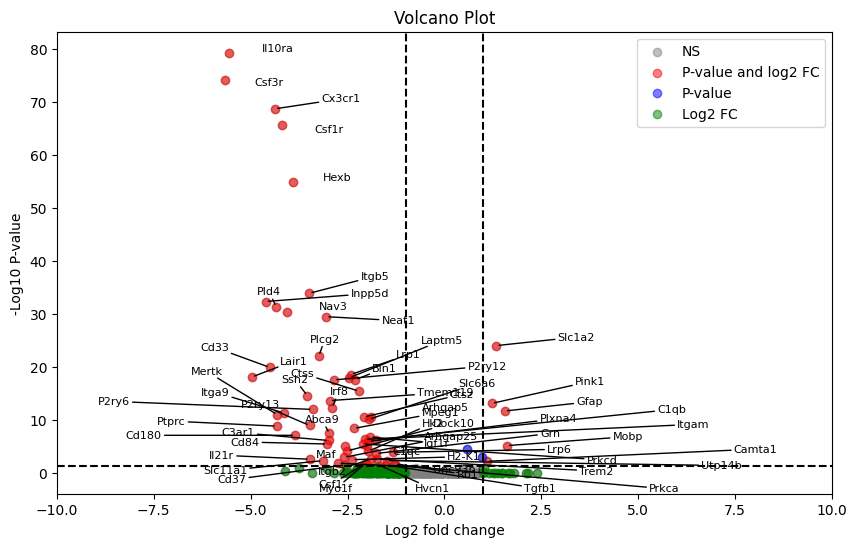

In [13]:
df_old = differential_expression(soma_old, dendrites_old)
soma_old_genes, branches_old_genes = plot_volcano(df_old, pval_col_suffix='_pvals_adj',xlims=[-10,10],sig_lfc=1)

/tmp/ipykernel_3380357/844682018.py:44: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata1.concatenate(adata2, batch_key='batch', batch_categories=['group1', 'group2'])


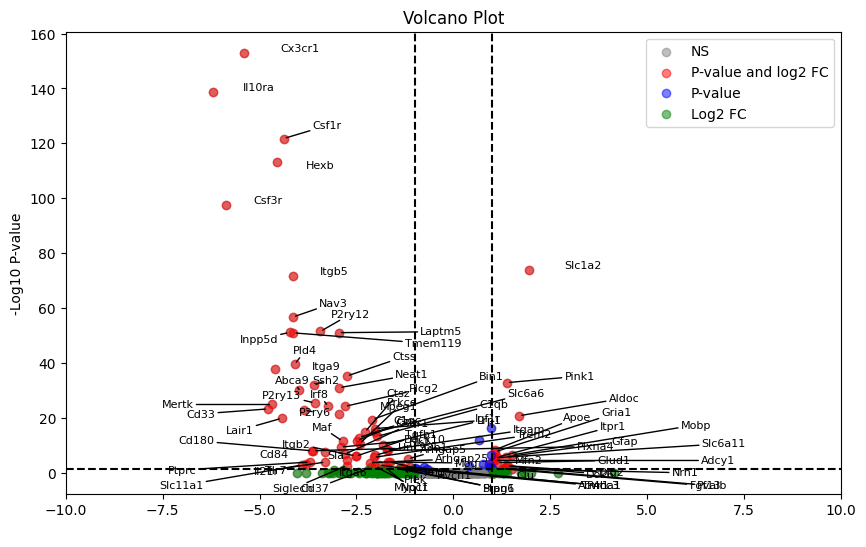

In [14]:
df_young = differential_expression(soma_young, dendrites_young)
soma_young_genes, branches_young_genes = plot_volcano(df_young, pval_col_suffix='_pvals_adj',xlims=[-10,10],sig_lfc=1)

/tmp/ipykernel_3380357/844682018.py:36: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata1.obs['group'] = 'group1'
/tmp/ipykernel_3380357/844682018.py:37: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata2.obs['group'] = 'group2'
/tmp/ipykernel_3380357/844682018.py:44: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata1.concatenate(adata2, batch_key='batch', batch_categories=['group1', 'group2'])


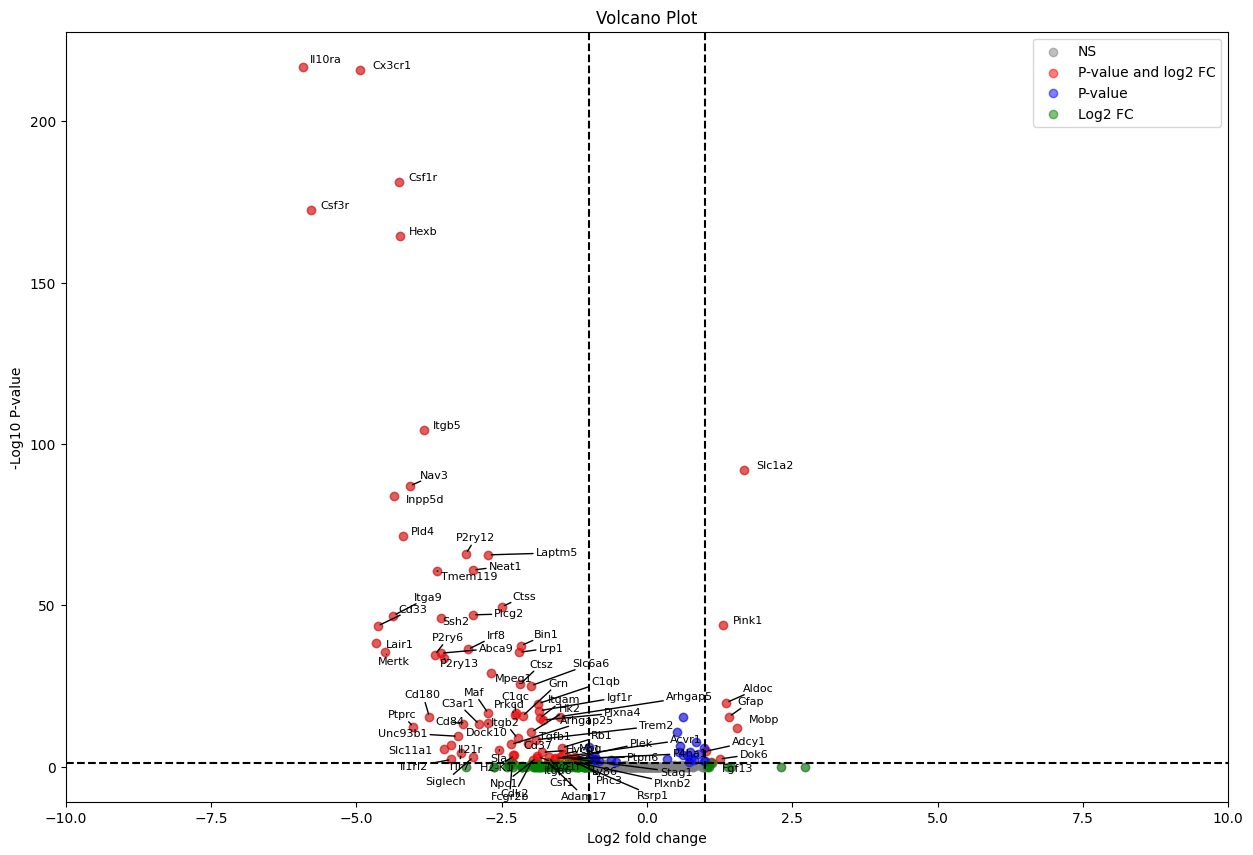

In [15]:
df_full = differential_expression(soma_full, dendrites_full)
soma_full_genes, branches_full_genes = plot_volcano(df_full, pval_col_suffix='_pvals_adj',xlims=[-10,10],sig_lfc=1,figsize=(15,10),savefig='Branches_over_soma.pdf')

In [16]:
enrichr_results = gp.enrichr(
    gene_list=soma_full_genes, 
    gene_sets='GO_Cellular_Component_2023',  # Database for cellular compartments
    organism='Mouse',  # Organism (can be 'Mouse', 'Human', etc.)
    )

    # Convert the results to a pandas DataFrame
df_results = enrichr_results.results
gp.barplot(enrichr_results.res2d, title='GO Enrichment', cutoff=0.05, figsize=(6,5),ofname=f'soma_enriched_compartment.pdf')

enrichr_results = gp.enrichr(
    gene_list=branches_full_genes, 
    gene_sets='GO_Cellular_Component_2023',  # Database for cellular compartments
    organism='Mouse',  # Organism (can be 'Mouse', 'Human', etc.)
    )

    # Convert the results to a pandas DataFrame
df_results = enrichr_results.results
gp.barplot(enrichr_results.res2d, title='GO Enrichment', cutoff=0.05, figsize=(6,5),ofname=f'branch_enriched_compartment.pdf')

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecat

In [17]:
branches_age = set(branches_young_genes) - set(branches_old_genes)
branches_age = [i for i in branches_age]

soma_age = set(soma_young_genes) - set(soma_old_genes)
soma_age = [i for i in soma_age]

print(f"Branches young: {len(branches_young_genes)}; Branches old: {len(branches_old_genes)}; Soma young: {len(soma_young_genes)}; Soma old:{len(soma_old_genes)}")
print(f"Branches common: {len(branches_full_genes)}; Soma common: {len(soma_full_genes)}")

Branches young: 18; Branches old: 5; Soma young: 67; Soma old:60
Branches common: 8; Soma common: 76


In [18]:
start_index = list(adata.obs.columns).index('Cell Area')  # Add 1 to include the column itself
columns_after_specific = adata.obs.iloc[:, start_index:].values

morphological_columns = adata.obs.columns[start_index:]

features = set(morphological_columns[:-6].tolist()) - set(['Ramification Index', 'Radius of Influence'])
features = [i for i in features]

In [19]:
corr_matrix_branches = calculate_spearman_corr(adata, branches_full_genes, features)
corr_matrix_soma = calculate_spearman_corr(adata, soma_full_genes, features)

corr_matrix_branches_3 = calculate_spearman_corr(adata[adata.obs.Age.isin(['3'])], branches_full_genes, features)
corr_matrix_branches_24 = calculate_spearman_corr(adata[adata.obs.Age.isin(['24'])], branches_full_genes, features)

In [20]:
def plot_avg_correlation(soma_corr_matrix, branch_corr_matrix,variable='Region',output_pdf=None):
    
    if variable == 'Region':
        # Calculate mean correlation for each morphological feature across all genes
        avg_soma_corr = soma_corr_matrix.mean(axis=0)  # Mean correlation for soma-enriched genes
        avg_branch_corr = branch_corr_matrix.mean(axis=0)  # Mean correlation for branch-enriched genes

        # Combine the averages into a DataFrame for easy plotting
        avg_corr_df = pd.DataFrame({
        'Branch': avg_branch_corr,
        'Soma': avg_soma_corr,
        })

        # Sort the DataFrame by branch correlations in descending order
        avg_corr_df = avg_corr_df.sort_values(by='Branch', ascending=False)

    # Create a bar plot with the average correlations
        avg_corr_df.plot(kind='bar', figsize=(10, 6))
        plt.title('Average Spearman Correlation by Morphological Feature (Sorted by Branch Correlation)')
        plt.ylabel('Average Correlation')
        plt.xlabel('Morphological Features')
        plt.xticks(rotation=90, ha='right')
        plt.tight_layout()
        if output_pdf:
            plt.savefig(f"{output_pdf}{variable}_spearman_correlation.pdf",format='pdf')
        plt.show()
    elif variable == 'Age':
        avg_soma_corr = soma_corr_matrix.mean(axis=0)  # Mean correlation for soma-enriched genes
        avg_branch_corr = branch_corr_matrix.mean(axis=0)  # Mean correlation for branch-enriched genes

        # Combine the averages into a DataFrame for easy plotting
        avg_corr_df = pd.DataFrame({
        '3m': avg_branch_corr,
        '24': avg_soma_corr,
        })

        # Sort the DataFrame by branch correlations in descending order
        avg_corr_df = avg_corr_df.sort_values(by='3m', ascending=False)

    # Create a bar plot with the average correlations
        avg_corr_df.plot(kind='bar', figsize=(10, 6))
        plt.title('Average Spearman Correlation by Morphological Feature (Sorted by 3m Correlation)')
        plt.ylabel('Average Correlation')
        plt.xlabel('Morphological Features')
        plt.xticks(rotation=90, ha='right')
        plt.tight_layout()
        if output_pdf:
            plt.savefig(f"{output_pdf}{variable}_spearman_correlation.pdf",format='pdf')
        plt.show()
        
    else:
        print(f"Make sure you are trying to plot transcript location or Age")

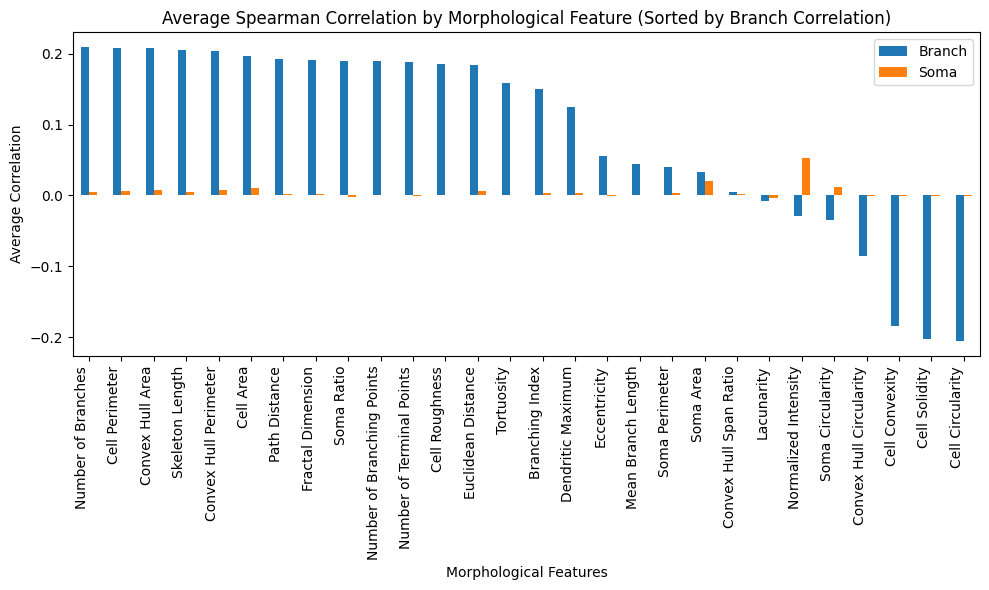

In [21]:
plot_avg_correlation(corr_matrix_soma,corr_matrix_branches,variable='Region',output_pdf='figures/')

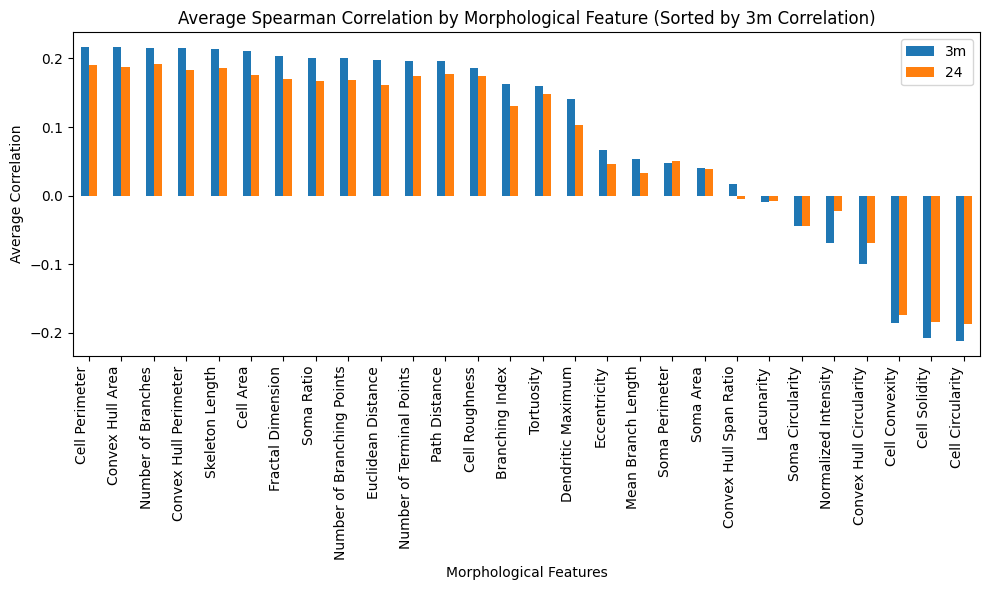

In [22]:
plot_avg_correlation(corr_matrix_branches_24,corr_matrix_branches_3,variable='Age',output_pdf='figures/')

# Scatter Plots

In [23]:
ad_test = combined_adata.copy()


ad_test.X = ad_test.layers['total_counts'].copy()

binarize_morphs = {
    0:'Ramified',
    1:'Activated',
    2:'Transition',
    3:'Activated',
    4:'Ramified'
}

ad_test.obs['sub_morph'] = ad_test.obs.morph_leiden.map(binarize_morphs)
adata_check = ad_test[(ad_test.obs.sub_morph.isin(['Activated','Ramified']))]# & (ad_test.obs.Age == '3')]
#adata_24 = ad_test[(ad_test.obs.sub_morph.isin(['Activated','Ramified']))]# & (ad_test.obs.Age == '24')]
#adata_3 = adata_3[:,branches_common]
#adata_24 = adata_24[:,branches_common]

adata_check = adata_check[:,branches_full_genes + soma_full_genes]
#adata_24 = adata_24[:,branches_full_genes + soma_full_genes]


sc.pp.normalize_total(adata_check,target_sum=1e4)
sc.pp.log1p(adata_check)
sc.pp.scale(adata_check,max_value=10)

sc.tl.pca(adata_check, svd_solver="arpack")

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [24]:
def scatter_with_split_marginal_density_aggregated(
    adata, gene_x='PC1', gene_y='PC2', color_by='ordered_morph', output_pdf=None
):
    """
    Create a scatter plot for specified axes (default PC1 vs PC2).
    Allows for `gene_x` and `gene_y` to be either genes in `adata.var_names`, numeric columns in `adata.obs`, or PCs.

    Parameters:
    -----------
    adata : AnnData
        The aggregated AnnData object.
    gene_x : str
        The name of the gene, numeric column, or PC for the x-axis.
    gene_y : str
        The name of the gene, numeric column, or PC for the y-axis.
    color_by : str
        The column in adata.obs used to color the data points.
    output_pdf : str, optional
        Path to save the plot as a PDF.

    Returns:
    --------
    None
        Displays the scatter plot.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns


    def get_data(adata, column):
        if column in adata.var_names:  # If column is a gene
            return adata[:, column].X.flatten()
        elif column in adata.obs.columns:  # If column is in obs
            return adata.obs[column].values
        elif column.startswith('PC') and 'X_pca' in adata.obsm:  # If column is a PC
            pc_index = int(column[2:]) - 1  # Convert "PC1" to index 0
            return adata.obsm['X_pca'][:, pc_index]
        else:
            raise ValueError(f"{column} not found in adata.var_names, adata.obs, or PCA results.")

    x_data = get_data(adata, gene_x)
    y_data = get_data(adata, gene_y)

    if color_by not in adata.obs.columns:
        raise ValueError(f"{color_by} column not found in adata.obs.")
    color_data = adata.obs[color_by]

    plot_data = pd.DataFrame({
        gene_x: x_data,
        gene_y: y_data,
        color_by: color_data
    })

    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        plot_data[gene_x],
        plot_data[gene_y],
        c=plot_data[color_by].astype('category').cat.codes,
        cmap='Set1',
        alpha=1,
        s=50
    )

    # Add a colorbar with labels from the color_by column
    cbar = plt.colorbar(scatter)
    cbar.set_label(color_by)
    cbar.set_ticks(range(len(plot_data[color_by].unique())))
    cbar.set_ticklabels(plot_data[color_by].unique())

    # Add titles and labels
    plt.title(f"Scatter Plot: {gene_x} vs {gene_y} (Aggregated)")
    plt.xlabel(gene_x)
    plt.ylabel(gene_y)

    # Save plot to PDF if specified
    if output_pdf:
        plt.savefig(output_pdf, format='pdf', bbox_inches='tight')

    plt.tight_layout()
    plt.show()

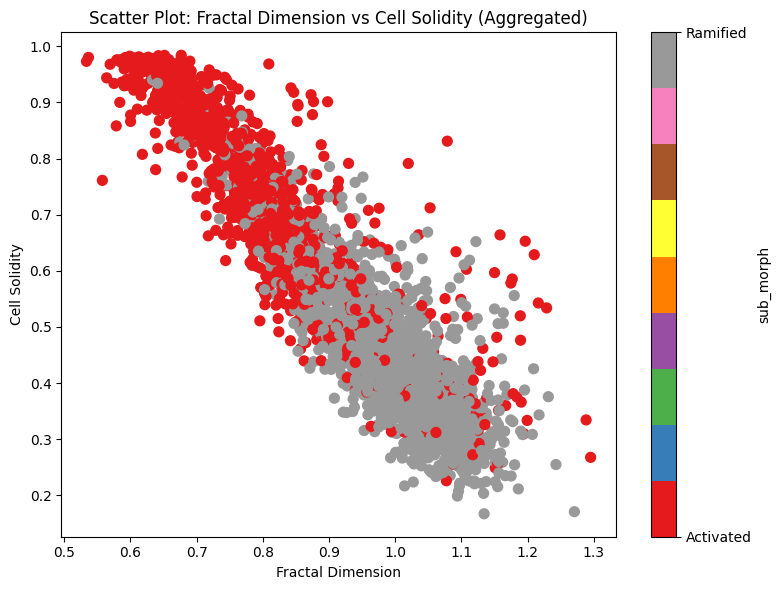

In [25]:
scatter_with_split_marginal_density_aggregated(adata_check, 'Fractal Dimension', 'Cell Solidity', color_by='sub_morph',output_pdf='Figures/Figure_4/morph_separation.pdf')

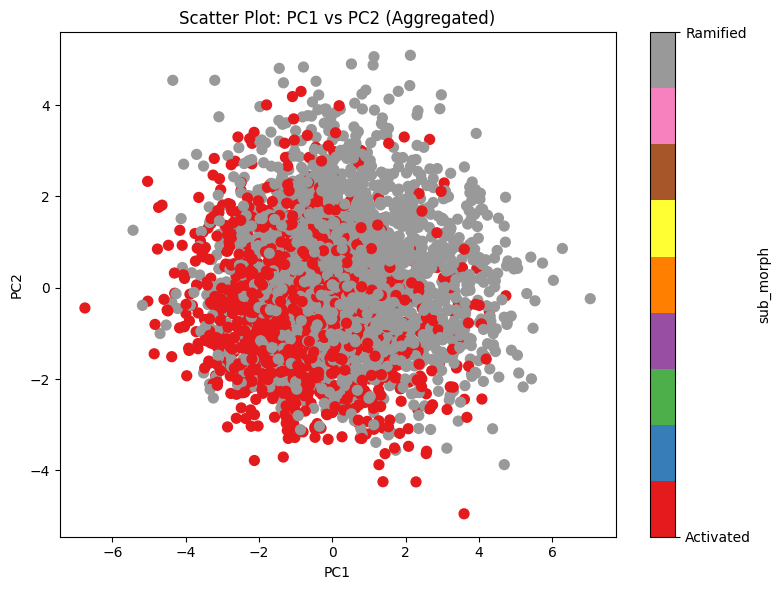

In [26]:
scatter_with_split_marginal_density_aggregated(adata_check, 'PC1', 'PC2', color_by='sub_morph',output_pdf='Figures/Figure_4/pc_separation.pdf')

# Model Creation

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import randint
from sklearn.inspection import permutation_importance

In [28]:
def analyze_adata_rf_list(adata_list, use_grid_search=False, use_random_search=False, output_pdf=None):
    """
    Analyze multiple AnnData objects using Random Forest classifiers. For each AnnData, 
    it plots the ROC-AUC curves on the same axis and outputs the feature importances for the genes in all models.
    
    Parameters:
    - adata_list: List of AnnData objects to analyze.
    - use_grid_search: Boolean indicating whether to use Grid Search for hyperparameter tuning.
    - use_random_search: Boolean indicating whether to use Random Search for hyperparameter tuning.
    
    Returns:
    - feature_importances_mdi_dict: A dictionary of MDI (Mean Decrease in Impurity) feature importances for each AnnData.
    - feature_importances_perm_dict: A dictionary of permutation feature importances for each AnnData.
    """
    # To store MDI and permutation importances for each AnnData
    feature_importances_mdi_dict = {}
    feature_importances_perm_dict = {}

    plt.figure(figsize=(10, 8))  # Initialize a single figure for all ROC curves
    age_list = ['3 month', '24 month']
    
    for idx, adata in enumerate(adata_list):
        print(f"Analyzing AnnData {idx + 1}/{len(adata_list)}")
        
        # Extract features and labels from the adata object
        X = adata.X
        y = adata.obs['sub_morph'].values
        label_encoder = LabelEncoder()
        y_binary = label_encoder.fit_transform(y)
        print(f"With the binary encoding sub_morph:{y[0]} is equivalent to {y_binary[0]}")

        # Split the data into training and validation sets
        X_train, X_val1, y_train, y_val1 = train_test_split(
            X.toarray() if hasattr(X, "toarray") else X, 
            y_binary, 
            test_size=0.2, 
            random_state=42
        )
        
        # Define the Random Forest model
        rf_model = RandomForestClassifier(random_state=42)
        
        # Hyperparameter tuning (optional)
        if use_grid_search:
            param_grid = {
                'n_estimators': [100, 200, 300, 400],
                'max_depth': [10, 20, 30, None],
                'min_samples_split': [2, 5, 10, 20],
                'min_samples_leaf': [1, 2, 4, 8],
                'bootstrap': [True, False]
            }
            grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                                       cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')
            grid_search.fit(X_train, y_train)
            rf_model = grid_search.best_estimator_
            print(f"Best parameters (Grid Search): {grid_search.best_params_}")
        
        elif use_random_search:
            param_dist = {
                'n_estimators': randint(100, 1000),
                'max_depth': [10, 20, 30, None],
                'min_samples_split': randint(2, 11),
                'min_samples_leaf': randint(1, 5),
                'bootstrap': [True, False]
            }
            random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, 
                                               n_iter=100, cv=3, n_jobs=-1, verbose=2, random_state=42, scoring='roc_auc')
            random_search.fit(X_train, y_train)
            rf_model = random_search.best_estimator_
            print(f"Best parameters (Random Search): {random_search.best_params_}")
        
        else:
            # Train the Random Forest model without tuning
            rf_model = RandomForestClassifier(
                n_estimators=200, 
                max_depth=20, 
                min_samples_split=5, 
                min_samples_leaf=2, 
                random_state=42
            )
            rf_model.fit(X_train, y_train)
        
        # Get ROC-AUC scores and predictions
        y_train_pred_prob = rf_model.predict_proba(X_train)[:, 1]
        y_val1_pred_prob = rf_model.predict_proba(X_val1)[:, 1]
        
        roc_auc_train = roc_auc_score(y_train, y_train_pred_prob)
        roc_auc_val1 = roc_auc_score(y_val1, y_val1_pred_prob)
        
        print(f"Random Forest - ROC AUC (Training): {roc_auc_train:.4f}")
        print(f"Random Forest - ROC AUC (Validation 1): {roc_auc_val1:.4f}")

        # Plot ROC curve on the same figure for each AnnData
        # Training set ROC curve
        fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
        plt.plot(fpr_train, tpr_train, label=f'{age_list[idx]} (Training AUC = {roc_auc_train:.2f})')

        # Validation set ROC curve
        fpr_val1, tpr_val1, _ = roc_curve(y_val1, y_val1_pred_prob)
        plt.plot(fpr_val1, tpr_val1, label=f'{age_list[idx]} (Validation AUC = {roc_auc_val1:.2f})')

        # Get feature names
        feature_names = adata.var_names
        
        # Store the feature importances (MDI) for this AnnData
        feature_importances_mdi = rf_model.feature_importances_
        feature_importances_mdi_df = pd.DataFrame({
        'Gene': feature_names,
        'Importance': feature_importances_mdi
        }).sort_values(by='Importance', ascending=False)

        feature_importances_mdi_dict[f'AnnData_{idx + 1}'] = feature_importances_mdi_df

        
        # Calculate permutation importance
        perm_importance = permutation_importance(rf_model, X_val1, y_val1, n_repeats=10, random_state=42, n_jobs=-1)
        perm_importance_df = pd.DataFrame({
        'Gene': feature_names,
        'Importance': perm_importance.importances_mean
        }).sort_values(by='Importance', ascending=False)

        
        feature_importances_perm_dict[f'AnnData_{idx + 1}'] = perm_importance_df
    
    # Finalize the ROC curve plot
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Random Forest (All AnnDatas)')
    plt.legend(loc="lower right")
    if output_pdf:
        plt.savefig(output_pdf, format='pdf')
    plt.show()

    return feature_importances_mdi_dict, feature_importances_perm_dict


In [29]:
ad_test = combined_adata.copy()


ad_test.X = ad_test.layers['total_counts'].copy()

binarize_morphs = {
    0:'Ramified',
    1:'Activated',
    2:'Transition',
    3:'Activated',
    4:'Ramified'
}

ad_test.obs['sub_morph'] = ad_test.obs.morph_leiden.map(binarize_morphs)
adata_full = ad_test[(ad_test.obs.sub_morph.isin(['Activated','Ramified']))]
adata_3 = ad_test[(ad_test.obs.sub_morph.isin(['Activated','Ramified'])) & (ad_test.obs.Age == '3')]
adata_24 = ad_test[(ad_test.obs.sub_morph.isin(['Activated','Ramified'])) & (ad_test.obs.Age == '24')]
adata_3 = adata_3[:,branches_full_genes]
adata_24 = adata_24[:,branches_full_genes]
adata_full_branches = adata_full[:,branches_full_genes]


sc.pp.normalize_total(adata_3,target_sum=1e4)
sc.pp.log1p(adata_3)

sc.pp.normalize_total(adata_24,target_sum=1e4)
sc.pp.log1p(adata_24)

sc.pp.normalize_total(adata_full_branches,target_sum=1e4)
sc.pp.log1p(adata_full_branches)

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/doug.henze/

Analyzing AnnData 1/2
With the binary encoding sub_morph:Activated is equivalent to 0
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters (Random Search): {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 521}
Random Forest - ROC AUC (Training): 0.8542
Random Forest - ROC AUC (Validation 1): 0.7542
Analyzing AnnData 2/2
With the binary encoding sub_morph:Activated is equivalent to 0
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters (Random Search): {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 521}
Random Forest - ROC AUC (Training): 0.8542
Random Forest - ROC AUC (Validation 1): 0.7542


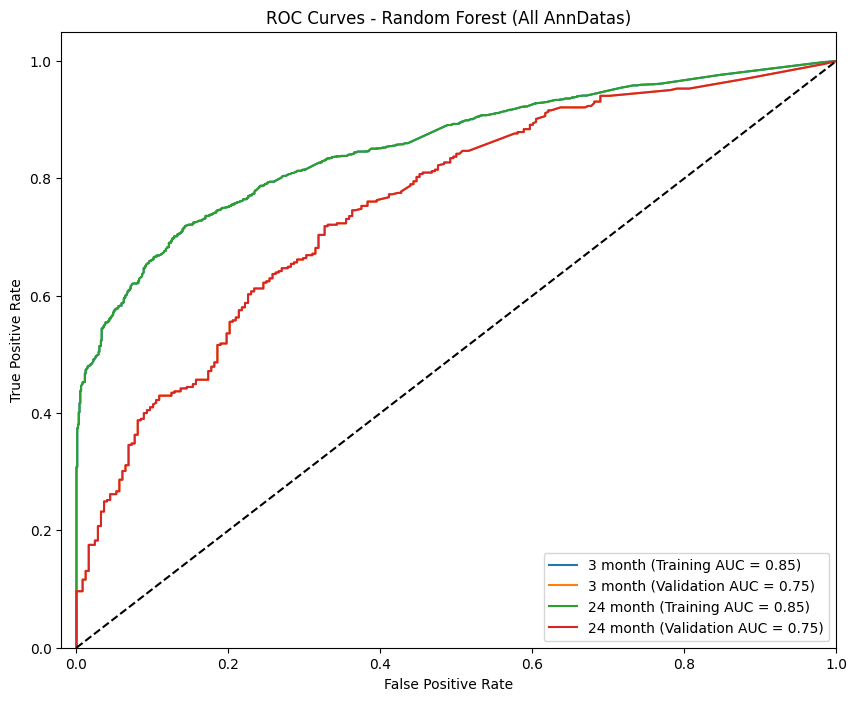

In [30]:
importances_mdi_whole, importances_perm_whole = analyze_adata_rf_list([adata_full_branches,adata_full_branches],use_random_search=True,output_pdf='figures/AUC_ROC_whole_m4_m5.pdf')

Analyzing AnnData 1/2
With the binary encoding sub_morph:Activated is equivalent to 0
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters (Random Search): {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 787}
Random Forest - ROC AUC (Training): 0.8911
Random Forest - ROC AUC (Validation 1): 0.7598
Analyzing AnnData 2/2
With the binary encoding sub_morph:Ramified is equivalent to 1
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters (Random Search): {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 260}
Random Forest - ROC AUC (Training): 0.8424
Random Forest - ROC AUC (Validation 1): 0.7812


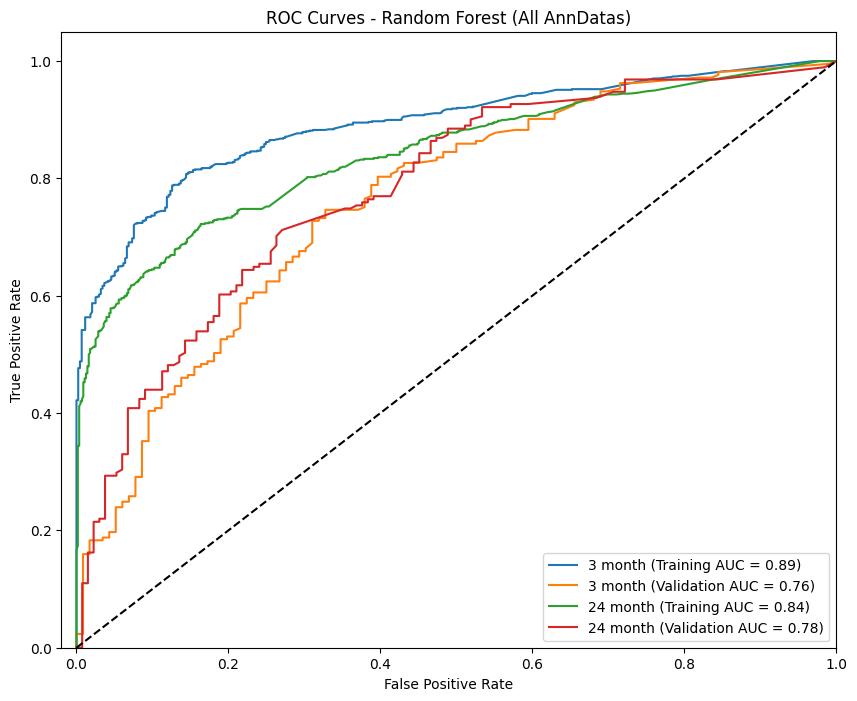

In [31]:
importances_mdi, importances_perm = analyze_adata_rf_list([adata_3,adata_24],use_random_search=True,output_pdf='figures/AUC_ROC_by_age.pdf')

In [32]:
def plot_feature_importance_comparison(feature_importances_dict,output_pdf=None):
    # Extract feature importance DataFrames for AnnData_1 and AnnData_2
    importance_1 = feature_importances_dict['AnnData_1']
    importance_2 = feature_importances_dict['AnnData_2']
    
    # Merge the two DataFrames on 'Gene' to align the genes
    merged_importances = pd.merge(importance_1, importance_2, on='Gene', suffixes=('_AnnData_1', '_AnnData_2'))
    
    # Plot the scatter plot comparing the importances
    plt.figure(figsize=(8, 6))
    plt.scatter(merged_importances['Importance_AnnData_1'], merged_importances['Importance_AnnData_2'], alpha=0.7)
    
    # Add a y = x diagonal line
    max_val = max(merged_importances[['Importance_AnnData_1', 'Importance_AnnData_2']].max())
    plt.plot([0, max_val], [0, max_val], 'r--', label='y=x')
    
    # Label the second highest importance value for each AnnData
    # Get the second highest importance for AnnData_1 and AnnData_2
    highest = importance_1.nlargest(2,'Importance').iloc[0]
    second_highest_1 = importance_1.nlargest(2, 'Importance').iloc[1]
    second_highest_2 = importance_2.nlargest(2, 'Importance').iloc[1]
    
    plt.annotate(highest['Gene'], 
                 xy=(highest['Importance'], merged_importances.loc[merged_importances['Gene'] == highest['Gene'], 'Importance_AnnData_2'].values[0]), 
                 xytext=(5, 5), textcoords='offset points', fontsize=10, color='black')
    
    # Annotate second-highest gene for AnnData_1
    plt.annotate(second_highest_1['Gene'], 
                 xy=(second_highest_1['Importance'], merged_importances.loc[merged_importances['Gene'] == second_highest_1['Gene'], 'Importance_AnnData_2'].values[0]), 
                 xytext=(5, 5), textcoords='offset points', fontsize=10, color='black')

    # Annotate second-highest gene for AnnData_2
    plt.annotate(second_highest_2['Gene'], 
                 xy=(merged_importances.loc[merged_importances['Gene'] == second_highest_2['Gene'], 'Importance_AnnData_1'].values[0], second_highest_2['Importance']), 
                 xytext=(5, 5), textcoords='offset points', fontsize=10, color='black')
    
    # Plot customizations
    plt.xlabel('Feature Importance (AnnData 1)')
    plt.ylabel('Feature Importance (AnnData 2)')
    plt.title('Comparison of Feature Importances Between AnnData 1 and AnnData 2')
    plt.grid(True)
    plt.legend(loc='best')
    plt.tight_layout()
    if output_pdf:
        plt.savefig(output_pdf,format='pdf')
    
    # Show the plot
    plt.show()
    
def plot_gene_importance(dataframe,savepdf=None):
    """
    Plots a bar plot of gene importance.

    Parameters:
        dataframe (pd.DataFrame): A DataFrame with columns 'Gene' and 'Importance'.
    """
    # Sort the dataframe by importance (optional, for better visualization)
    dataframe = dataframe.sort_values(by='Importance', ascending=False)

    # Set the plot style
    sns.set(style="whitegrid")

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Gene', y='Importance', data=dataframe, palette="viridis")

    # Customize the plot
    plt.title('Gene Importance', fontsize=16)
    plt.xlabel('Gene', fontsize=14)
    plt.ylabel('Importance', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.tight_layout()
    if savepdf:
        plt.savefig(savepdf,format='pdf')

    # Show the plot
    plt.show()

/tmp/ipykernel_3380357/3004230065.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gene', y='Importance', data=dataframe, palette="viridis")


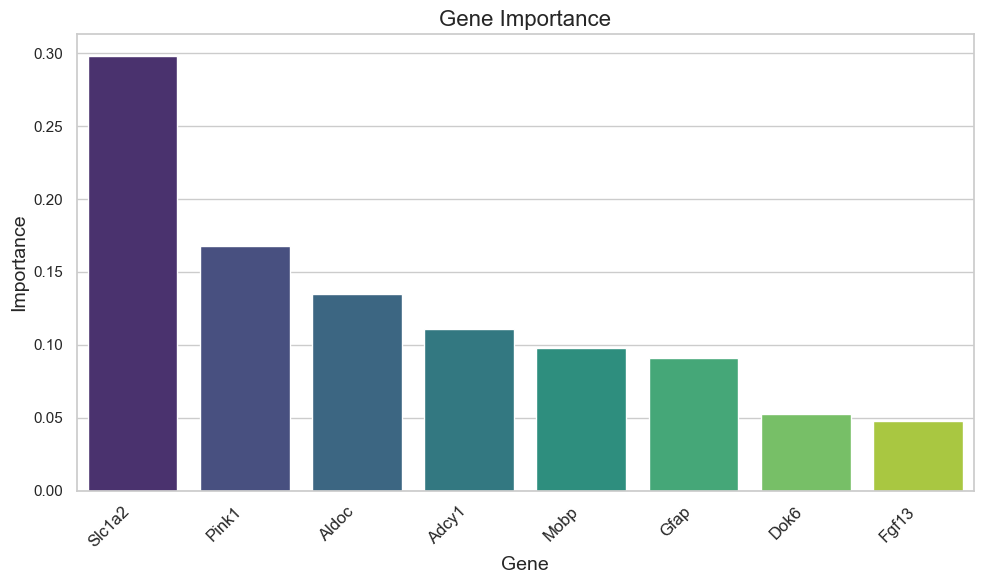

In [33]:
plot_gene_importance(importances_mdi_whole['AnnData_1'],savepdf='figures/MDI_importance_whole.pdf')

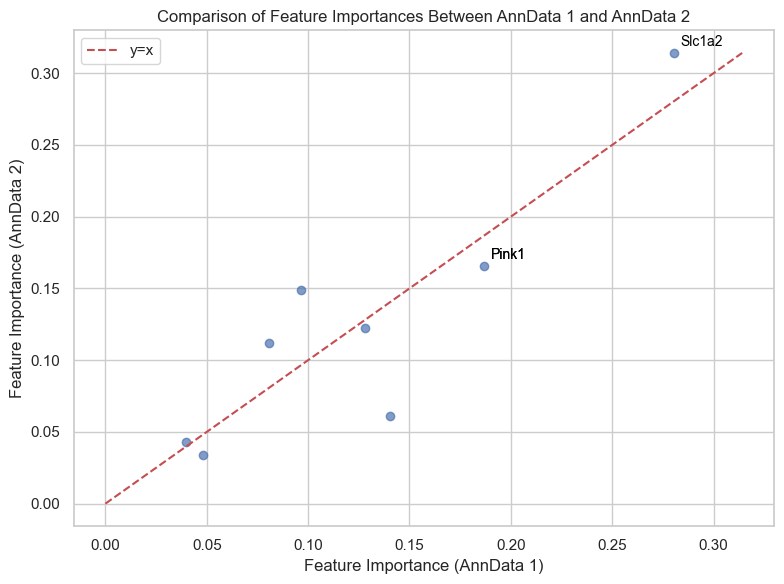

In [34]:
plot_feature_importance_comparison(importances_mdi,output_pdf='figures/MDI_importance_age.pdf')

# Clustermaps

In [35]:
from scipy.stats import zscore
from nheatmap import nhm

def create_pseudobulk(adata, cluster_col='morph_leiden', batch_col='batchID'):
    # Create a unique identifier for each cluster-batch pair
    adata.obs['pseudobulk_id'] = adata.obs[cluster_col].astype(str) + '.' + adata.obs[batch_col].astype(str)
    
    # Group the data by the pseudobulk_id
    groups = adata.obs['pseudobulk_id'].unique()
    pseudobulk_data = []
    pseudobulk_obs = []
    
    for group in groups:
        # Subset the data for each group
        group_mask = adata.obs['pseudobulk_id'] == group
        group_data = adata[group_mask, :].X.mean(axis=0)  # Sum the expression values
        pseudobulk_data.append(group_data)
        
        # Collect the metadata
        cluster, batch= group.split('.')
        pseudobulk_obs.append({'pseudobulk_id': group, cluster_col: cluster, batch_col: batch, 'Age': batch.split('-')[0] , 'Sex': batch.split('-')[2]})
    
    # Convert the list to a numpy array
    pseudobulk_data = np.array(pseudobulk_data)
    #print(pseudobulk_data[:,0,:].shape)
    #print(pseudobulk_data.shape)
    
    # Create a new AnnData object for the pseudobulked data
    pseudobulk_adata = sc.AnnData(X=pseudobulk_data)
    
    # Add the metadata
    pseudobulk_adata.obs = pd.DataFrame(pseudobulk_obs)
    
    # Copy variable names (genes) from the original data
    pseudobulk_adata.var = adata.var.copy()
    
    return pseudobulk_adata

def concatenate_nuclear_non_nuclear(adata_nuclear, adata_non_nuclear):
    """
    Concatenates two AnnData objects (nuclear and non-nuclear) and adds a metadata column 
    distinguishing between them.

    Parameters:
    - adata_nuclear: AnnData object for nuclear counts
    - adata_non_nuclear: AnnData object for non-nuclear counts

    Returns:
    - A concatenated AnnData object with an additional 'Count_Type' column in obs
    """

    # Add a new column 'Count_Type' to distinguish the two datasets
    adata_nuclear.obs['Location_of_Transcripts'] = 'soma'
    adata_non_nuclear.obs['Location_of_Transcripts'] = 'non-soma'

    # Concatenate the two AnnData objects
    adata_combined = adata_nuclear.concatenate(adata_non_nuclear, join='outer')

    return adata_combined

In [36]:
soma_ad = soma_young.concatenate(soma_old, join='outer')
branch_ad = dendrites_young.concatenate(dendrites_old, join='outer')

/tmp/ipykernel_3380357/568776634.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  soma_ad = soma_young.concatenate(soma_old, join='outer')
/tmp/ipykernel_3380357/568776634.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  branch_ad = dendrites_young.concatenate(dendrites_old, join='outer')


In [37]:
young_genes = set(soma_young_genes[:10] + branches_young_genes[:15])
young_genes = [i for i in young_genes]

old_genes = set(soma_old_genes[:10] + branches_old_genes[:15])
old_genes = [i for i in old_genes]

total_genes = set(soma_full_genes[:10] + branches_full_genes[:15])
total_genes = [i for i in total_genes]

/tmp/ipykernel_3380357/1523548440.py:57: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata_nuclear.concatenate(adata_non_nuclear, join='outer')
/tmp/ipykernel_3380357/1523548440.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['pseudobulk_id'] = adata.obs[cluster_col].astype(str) + '.' + adata.obs[batch_col].astype(str)
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/nheatmap/plot.py:345: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mapped_df = df.replace(tick_dictionary)


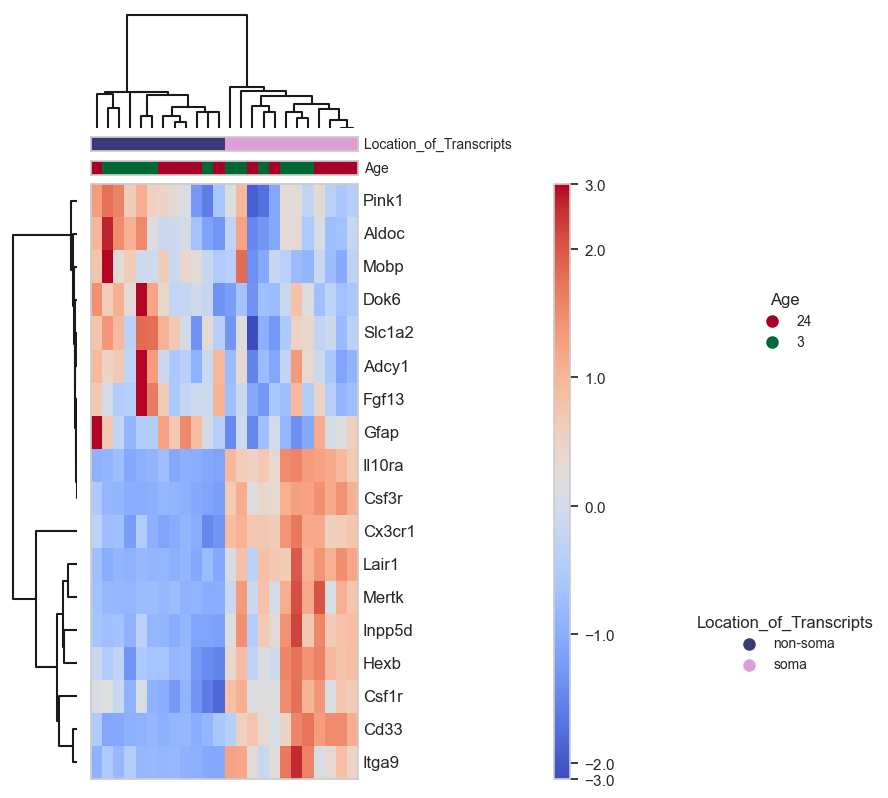

In [38]:
total_comp = concatenate_nuclear_non_nuclear(soma_ad,branch_ad)

pseudo = create_pseudobulk(total_comp[:,total_genes],cluster_col='Location_of_Transcripts')

counts_matrix = pseudo.X
gene_names = pseudo.var_names
cell_names = pseudo.obs_names

# Create the DataFrame with obs_names as rows and var_names as columns
counts_df = pd.DataFrame(data=counts_matrix, index=cell_names, columns=gene_names)
zscored_df = counts_df.apply(zscore, axis=0)

subset_df = zscored_df

dfc = pseudo.obs.loc[:,['Location_of_Transcripts','Age']]
dfr = pseudo.obs.loc[:,['Location_of_Transcripts']]

dfr_sorted = dfr.sort_values(by='Location_of_Transcripts')

# Reorder `subset_df` to match the order of `dfr_sorted`
subset_df_reordered = subset_df.loc[dfr_sorted.index]

cmaps={'batchID':'Location_of_Transcripts', 'Age':'RdYlGn', 'Sex':'inferno',
        'PC score':'gist_heat', 'PC score 2':'rainbow'}

clipped_data = subset_df.T.clip(upper=2.5)
g = nhm(data=clipped_data, dfc=dfc, figsize=(10, 10), linewidths=0, cmaps=cmaps, showxticks=False,cmapCenter='coolwarm')
g.hcluster(method='single', metric='cosine', optimal_ordering=False)
fig, plots = g.run()
fig.savefig('figures/total_gene_clustering_m4_m5.pdf', bbox_inches='tight')

/tmp/ipykernel_3380357/1523548440.py:57: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata_nuclear.concatenate(adata_non_nuclear, join='outer')
/tmp/ipykernel_3380357/1523548440.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['pseudobulk_id'] = adata.obs[cluster_col].astype(str) + '.' + adata.obs[batch_col].astype(str)
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/nheatmap/plot.py:345: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mapped_df = df.replace(tick_dictionary)


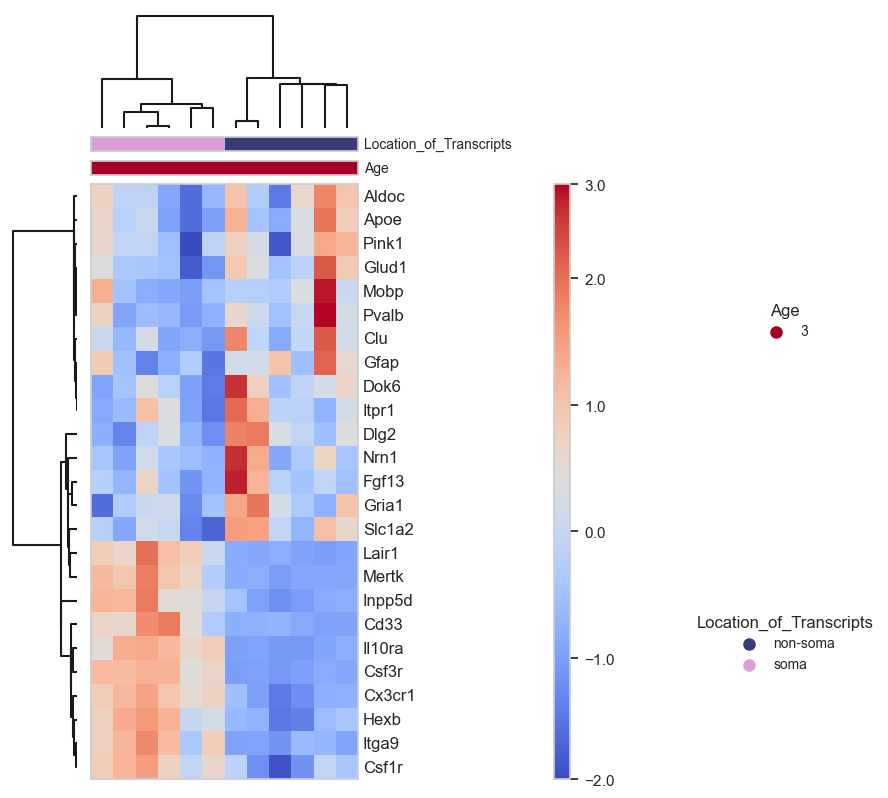

In [39]:
total_young = concatenate_nuclear_non_nuclear(soma_young,dendrites_young)

pseudo = create_pseudobulk(total_young[:,young_genes],cluster_col='Location_of_Transcripts')

counts_matrix = pseudo.X
gene_names = pseudo.var_names
cell_names = pseudo.obs_names

# Create the DataFrame with obs_names as rows and var_names as columns
counts_df = pd.DataFrame(data=counts_matrix, index=cell_names, columns=gene_names)
zscored_df = counts_df.apply(zscore, axis=0)

subset_df = zscored_df

dfc = pseudo.obs.loc[:,['Location_of_Transcripts','Age']]
dfr = pseudo.obs.loc[:,['Location_of_Transcripts']]

dfr_sorted = dfr.sort_values(by='Location_of_Transcripts')

# Reorder `subset_df` to match the order of `dfr_sorted`
subset_df_reordered = subset_df.loc[dfr_sorted.index]

cmaps={'batchID':'Location_of_Transcripts', 'Age':'RdYlGn', 'Sex':'inferno',
        'PC score':'gist_heat', 'PC score 2':'rainbow'}

g = nhm(data=subset_df.T, dfc=dfc, figsize=(10, 10), linewidths=0, cmaps=cmaps, showxticks=False,cmapCenter='coolwarm')
g.hcluster(method='single', metric='cosine', optimal_ordering=False)
fig, plots = g.run()
fig.savefig('figures/young_gene_clustering.pdf', bbox_inches='tight')

/tmp/ipykernel_3380357/1523548440.py:57: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata_nuclear.concatenate(adata_non_nuclear, join='outer')
/tmp/ipykernel_3380357/1523548440.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['pseudobulk_id'] = adata.obs[cluster_col].astype(str) + '.' + adata.obs[batch_col].astype(str)
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/nheatmap/plot.py:345: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mapped_df = df.replace(tick_dictionary)


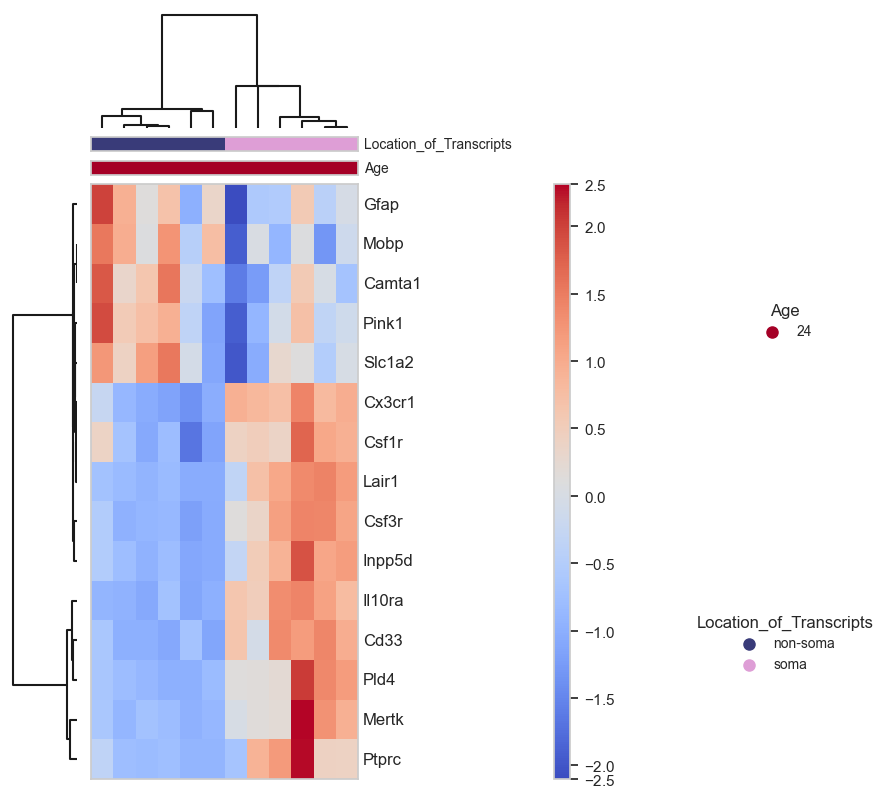

[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=415; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=4, n_estimators=868; total time=   1.3s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=4, n_estimators=503; total time=   0.8s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=3, n_estimators=892; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=3, min_samples_split=4, n_estimators=305; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=9, n_estimators=904; total time=   1.1s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=4, n_estimators=759; total time=   1.1s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=3, n_estimators=892; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=

In [40]:
total_old = concatenate_nuclear_non_nuclear(soma_old,dendrites_old)

pseudo = create_pseudobulk(total_old[:,old_genes],cluster_col='Location_of_Transcripts')

counts_matrix = pseudo.X
gene_names = pseudo.var_names
cell_names = pseudo.obs_names

# Create the DataFrame with obs_names as rows and var_names as columns
counts_df = pd.DataFrame(data=counts_matrix, index=cell_names, columns=gene_names)
zscored_df = counts_df.apply(zscore, axis=0)

subset_df = zscored_df

dfc = pseudo.obs.loc[:,['Location_of_Transcripts','Age']]
dfr = pseudo.obs.loc[:,['Location_of_Transcripts']]

dfr_sorted = dfr.sort_values(by='Location_of_Transcripts')

# Reorder `subset_df` to match the order of `dfr_sorted`
subset_df_reordered = subset_df.loc[dfr_sorted.index]

cmaps={'batchID':'Location_of_Transcripts', 'Age':'RdYlGn', 'Sex':'inferno',
        'PC score':'gist_heat', 'PC score 2':'rainbow'}

g = nhm(data=subset_df.T, dfc=dfc, figsize=(10, 10), linewidths=0, cmaps=cmaps, showxticks=False,cmapCenter='coolwarm')
g.hcluster(method='single', metric='cosine', optimal_ordering=False)
fig, plots = g.run()
fig.savefig('figures/old_gene_clustering.pdf', bbox_inches='tight')